In [4]:
using VegaLite, CSV, DataFrames, DelimitedFiles, Statistics, Base.Filesystem, PrettyTables, Query, VegaDatasets

┌ Info: Precompiling VegaDatasets [0ae4a718-28b7-58ec-9efb-cded64d6d5b4]
└ @ Base loading.jl:1273


In [21]:
provs = [:ontario, :alberta, :bc, :manitoba, :newbruns, :newfdland, :nwterrito, :novasco, :nunavut, :pei, :quebec, :saskat, :yukon]

r0 = "b00455" #b00455/ 
prov = "ontario"
tf = "tau0_f00"
ag = "all"

prefix = ("D:\\data\\simresults\\$prov\\$r0\\")

"D:\\data\\simresults\\ontario\\b00455\\"

In [6]:
df_tavg = CSV.read("$prefix\\$tf\\timelevel_$ag.dat");

df_tavg = df_tavg |> @filter(_.time <= 300) |> DataFrame ## go to only 300 days

pretty_table(df_tavg)

# print stats
totalinfected = round(sum(df_tavg.lat_inc), digits=2)
ar = round(totalinfected / 10000, digits=2)
println("total infected: $totalinfected, attack rate: $ar")

ArgumentError: ArgumentError: "D:\data\simresults\ontario\b00455\\tau0_f00\timelevel_all.dat" is not a valid file

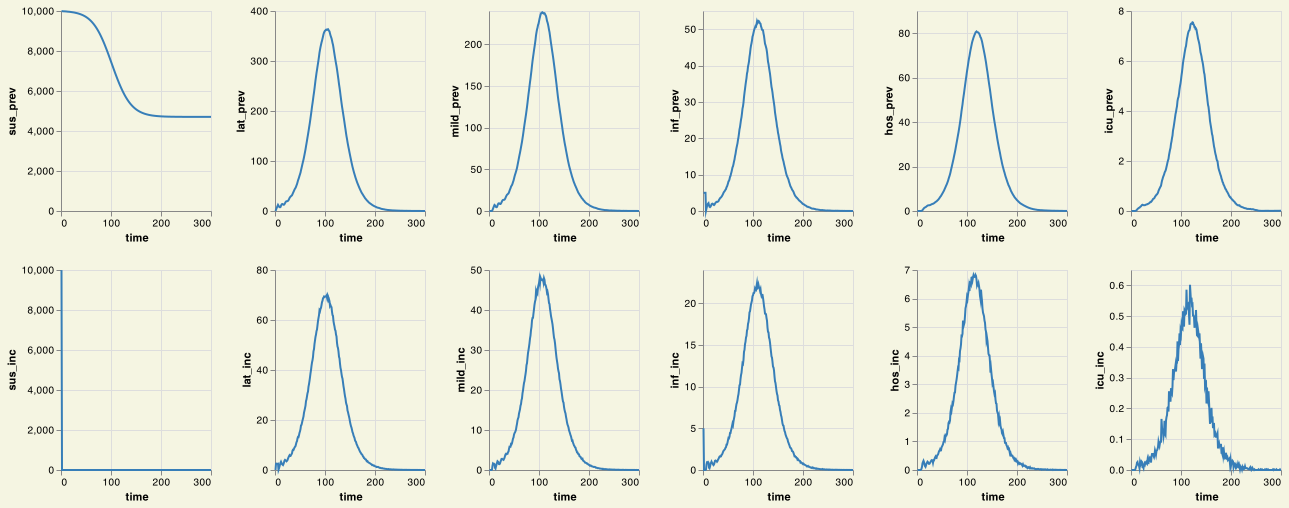

In [81]:
## plot the columns of the time average of all simulations
spec1 = df_tavg |> 
@vlplot(repeat=[:sus_prev, :lat_prev, :mild_prev, :inf_prev, :hos_prev, :icu_prev,
                :sus_inc, :lat_inc, :mild_inc, :inf_inc, :hos_inc, :icu_inc], columns=6, config = {background="#f5f5e2"}) + 
(
    @vlplot(
        x="time:q",
        y={field={repeat=:repeat}, type="quantitative"},
        width=150,
        height=200
    ) + 
    @vlplot(
        mark={
            type=:line, 
            color="#377eb8",
            size=2
        }
    )
)
#spec1 |> save("myfigure.vegalite")
#pwd()


In [16]:
## looks at the total incidence of icu and hosp
icuinc = CSV.read("$prefix/$tf/simlevel_icu_inc_$ag.dat")[:, 2:end]  ## first column is time.
hosinc = CSV.read("$prefix/$tf/simlevel_hos_inc_$ag.dat")[:, 2:end]  ## first column is time.
sums_icu = sum.(eachcol(icuinc))
mval_icu = mean(sums_icu)
qlo_icu = quantile(sums_icu, 0.025)
qhi_icu = quantile(sums_icu, 0.975)
println("ICU stats: mean: $mval_icu, qlo: $qlo_icu, qhi: $qhi_icu")        

sums_hos = sum.(eachcol(hosinc))
mval_hos = mean(sums_hos)
qlo_hos = quantile(sums_hos, 0.025)
qhi_hos = quantile(sums_hos, 0.975)
println("HOS stats: mean: $mval_hos, qlo: $qlo_hos, qhi: $qhi_hos")        


ICU stats: mean: 41.216, qlo: 29.0, qhi: 55.0
HOS stats: mean: 519.348, qlo: 458.475, qhi: 583.525


In [140]:
mysums_noiso = []
mysums_iso10 = []
mysums_iso20 = []
mysums_iso40 = []
for p in provs
    r0 = "b00455" #b00455/ 
    ag = "all"
    prov = p
    icu_prev = CSV.read("D:\\data\\simresults\\$prov\\$r0\\tau0_f00\\simlevel_icu_prev_$ag.dat")[:, 2:end]  ## first column is time.
    icu_prev_10 = CSV.read("D:\\data\\simresults\\$prov\\$r0\\tau1_f01\\simlevel_icu_prev_$ag.dat")[:, 2:end]  ## first column is time.
    icu_prev_20 = CSV.read("D:\\data\\simresults\\$prov\\$r0\\tau1_f02\\simlevel_icu_prev_$ag.dat")[:, 2:end]  ## first column is time.
    icu_prev_40 = CSV.read("D:\\data\\simresults\\$prov\\$r0\\tau1_f04\\simlevel_icu_prev_$ag.dat")[:, 2:end]  ## first column is time.

    colsums_0 = sum.(eachcol(icu_prev))
    colsums_10 = sum.(eachcol(icu_prev_10))
    colsums_20 = sum.(eachcol(icu_prev_20))
    colsums_40 = sum.(eachcol(icu_prev_40))
    push!(mysums_noiso, colsums_0)
    push!(mysums_iso10, colsums_10)
    push!(mysums_iso20, colsums_20)
    push!(mysums_iso40, colsums_40)    
end

function processdf(mysums, name)
    _tmpdf = DataFrame(transpose(hcat(mysums...)))
    colnames = names(_tmpdf)
    insertcols!(_tmpdf, 1, :prov => provs)
    insertcols!(_tmpdf, 2, :iso => name)
    _tmpdf = stack(_tmpdf, colnames)    
end

_tmpdf = vcat(processdf(mysums_noiso, "noiso"), 
              processdf(mysums_iso10, "iso10"),
              processdf(mysums_iso20, "iso20"),
              processdf(mysums_iso40, "iso40"))

        

#total beds / total pop size * 10000 and compare with mean of what we have in the table 40% isolation

26000×4 DataFrame
│ Row   │ variable │ value │ prov      │ iso    │
│       │ Symbol   │ Int64 │ Symbol    │ String │
├───────┼──────────┼───────┼───────────┼────────┤
│ 1     │ x1       │ 513   │ ontario   │ noiso  │
│ 2     │ x1       │ 718   │ alberta   │ noiso  │
│ 3     │ x1       │ 633   │ bc        │ noiso  │
│ 4     │ x1       │ 663   │ manitoba  │ noiso  │
│ 5     │ x1       │ 527   │ newbruns  │ noiso  │
│ 6     │ x1       │ 560   │ newfdland │ noiso  │
│ 7     │ x1       │ 480   │ nwterrito │ noiso  │
│ 8     │ x1       │ 594   │ novasco   │ noiso  │
│ 9     │ x1       │ 474   │ nunavut   │ noiso  │
│ 10    │ x1       │ 375   │ pei       │ noiso  │
⋮
│ 25990 │ x500     │ 317   │ bc        │ iso40  │
│ 25991 │ x500     │ 300   │ manitoba  │ iso40  │
│ 25992 │ x500     │ 233   │ newbruns  │ iso40  │
│ 25993 │ x500     │ 253   │ newfdland │ iso40  │
│ 25994 │ x500     │ 238   │ nwterrito │ iso40  │
│ 25995 │ x500     │ 135   │ novasco   │ iso40  │
│ 25996 │ x500     │ 0     │ nunavut   │ iso40  │
│ 25997 │ x500     │ 325   │ pei       │ iso40  │
│ 25998 │ x500     │ 389   │ quebec    │ iso40  │
│ 25999 │ x500     │ 225   │ saskat    │ iso40  │
│ 26000 │ x500     │ 14    │ yukon     │ iso40  │

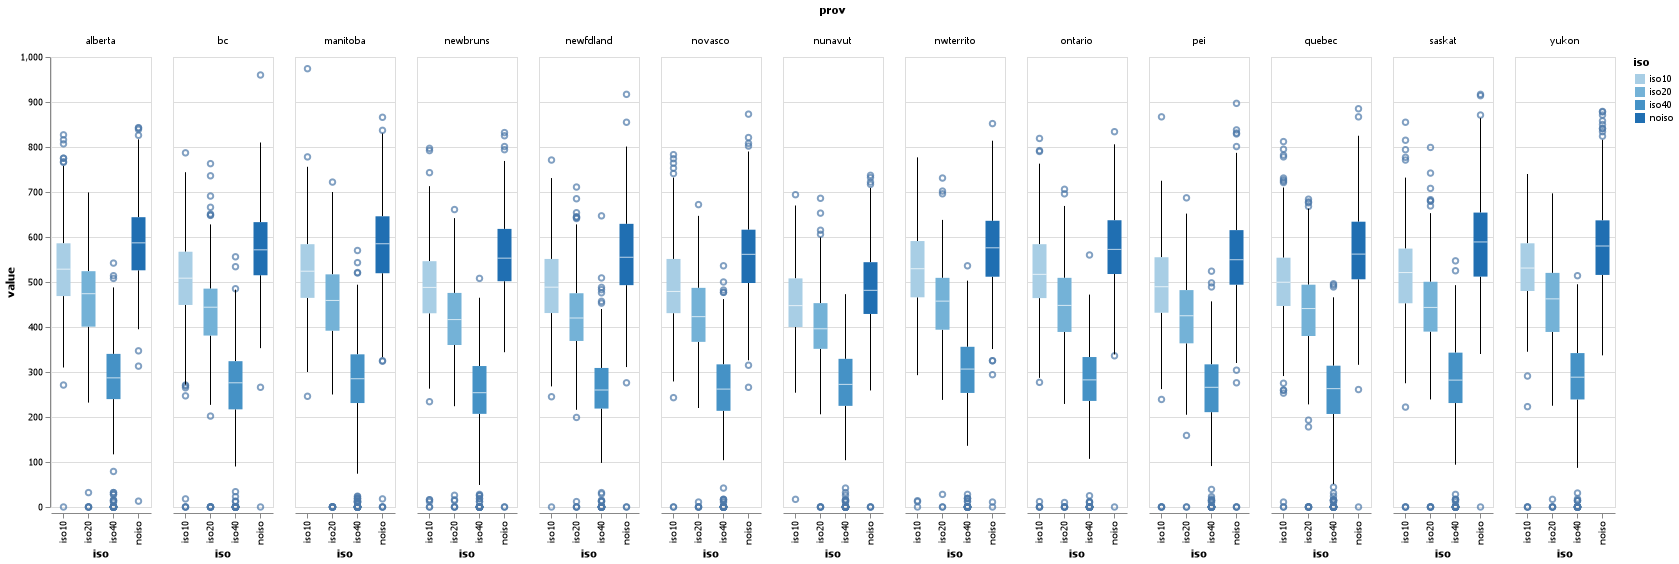

In [158]:
spec1 = _tmpdf |> 

@vlplot(  
    mark={"boxplot"},
    column={field="prov",type="ordinal"},
    y = {field="value", type="quantitative", grid=:false, gridColor="white"},
    x = {field="iso", type="ordinal", ticks=false},
    color={field="iso", type="ordinal"},
    width=100,
    height=450
) 
#spec1 |> save("myfigure.vegalite")

In [5]:
 nydata = CSV.read("D:\\data\\nydata.dat")  ## first column is time.
 colnames = names(nydata)
insertcols!(nydata, 1, :sim => 1:5000)
_tmpdf = stack(nydata, colnames)

90000×3 DataFrame
│ Row   │ variable │ value   │ sim   │
│       │ Symbol   │ Float64 │ Int64 │
├───────┼──────────┼─────────┼───────┤
│ 1     │ x1       │ 1.0     │ 1     │
│ 2     │ x1       │ 0.0     │ 2     │
│ 3     │ x1       │ 2.0     │ 3     │
│ 4     │ x1       │ 2.0     │ 4     │
│ 5     │ x1       │ 3.0     │ 5     │
│ 6     │ x1       │ 1.0     │ 6     │
│ 7     │ x1       │ 1.0     │ 7     │
│ 8     │ x1       │ 8.0     │ 8     │
│ 9     │ x1       │ 1.0     │ 9     │
│ 10    │ x1       │ 0.0     │ 10    │
⋮
│ 89990 │ x18      │ 3.0     │ 4990  │
│ 89991 │ x18      │ 0.0     │ 4991  │
│ 89992 │ x18      │ 1.0     │ 4992  │
│ 89993 │ x18      │ 1.0     │ 4993  │
│ 89994 │ x18      │ 0.0     │ 4994  │
│ 89995 │ x18      │ 0.0     │ 4995  │
│ 89996 │ x18      │ 1.0     │ 4996  │
│ 89997 │ x18      │ 0.0     │ 4997  │
│ 89998 │ x18      │ 1.0     │ 4998  │
│ 89999 │ x18      │ 0.0     │ 4999  │
│ 90000 │ x18      │ 1.0     │ 5000  │

In [20]:
## map plot
features = ["CA-SK", "CA-AB", "CA-BC", "CA-NU", "CA-ON", "CA-QC", "CA-NB", "CA-NS", "CA-LA", "CA-PE"]
dat = [0.863374694, 1.014754255, 1.351297778, 1.180046602, 1.422717627, 2.024011979, 1.939875, 2.589888387, 2.348566575, 2.535347368]
df = DataFrame(id=features, dat=dat)
display(df)
println(length(dat))


#Newfoundland	0.863374694
#Nova Scotia	1.014754255
#Prince Edward Island	1.351297778
#New Brunswick	1.180046602
#Quebec	1.422717627
#Ontario	2.024011979
#Saskatchewan	1.939875
#Manitoba	2.589888387
#Alberta	2.348566575
#British Columbia	2.535347368


10×2 DataFrame
│ Row │ id     │ dat      │
│     │ String │ Float64  │
├─────┼────────┼──────────┤
│ 1   │ CA-SK  │ 0.863375 │
│ 2   │ CA-AB  │ 1.01475  │
│ 3   │ CA-BC  │ 1.3513   │
│ 4   │ CA-NU  │ 1.18005  │
│ 5   │ CA-ON  │ 1.42272  │
│ 6   │ CA-QC  │ 2.02401  │
│ 7   │ CA-NB  │ 1.93988  │
│ 8   │ CA-NS  │ 2.58989  │
│ 9   │ CA-LA  │ 2.34857  │
│ 10  │ CA-PE  │ 2.53535  │

10


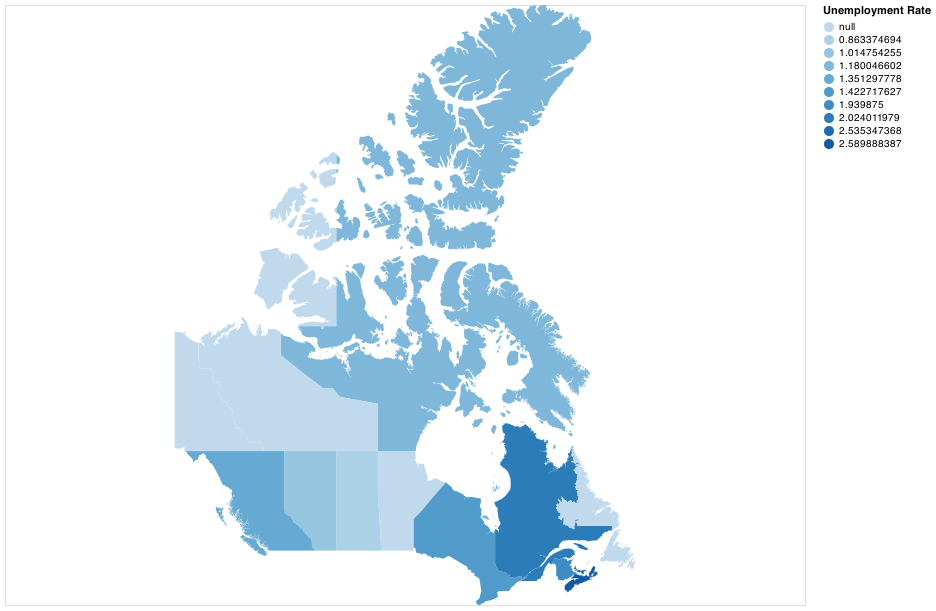

In [29]:
spec1 = @vlplot(width=800, height=600) + 
@vlplot(
    mark={ 
        :geoshape
    },
    data={
        url="/Users/abmlab/OneDrive/Documents/postdoc projects/2019-ncov/scripts/abm_model/canadamap.json",
        format={
            type=:topojson,
            feature=:canadaprov
        }
    }, 
    transform=[{
    lookup=:id,
    from={
        data=df,
        key=:id,
        fields=["dat"]
    }
    }],
    color={
    "dat:o",
    scale={scheme=:blues},
    legend={title="Unemployment Rate"}
    }
)
#spec1 |> save("mymap.vegalite")

In [6]:
vlspec =
{
  "width": 800,
  "height": 600,
  "layer": [
    {
      "mark": {
        "type": "geoshape", 
        "stroke": "black"
      },
      "data": {
        "url": "https://gist.githubusercontent.com/Brideau/2391df60938462571ca9/raw/f5a1f3b47ff671eaf2fb7e7b798bacfc6962606a/canadaprovtopo.json",
        "format": {
          "type": "topojson",
          "feature": "canadaprov"
        }
      },
      "transform": [
        {
          "lookup": "id",
          "from": {
            "data": {
              "values": [
                {
                  "id": "CA-SK",
                  "dat": 1.939875
                },
                {
                  "id": "CA-AB",
                  "dat": 2.348566575
                },
                {
                  "id": "CA-BC",
                  "dat": 2.535347368
                },
                {
                  "id": "CA-MB",
                  "dat": 2.589888387
                },
                {
                  "id": "CA-ON",
                  "dat": 2.024011979
                },
                {
                  "id": "CA-QC",
                  "dat": 1.422717627
                },
                {
                  "id": "CA-NB",
                  "dat": 1.180046602
                },
                {
                  "id": "CA-NS",
                  "dat": 1.014754255
                },
                {
                  "id": "CA-NL",
                  "dat": 0.863374694
                },
                {
                  "id": "CA-PE",
                  "dat": 1.351297778
                }, 
                {
                  "id": "CA-YT",
                  "dat": 0
                },
                {
                  "id": "CA-NU",
                  "dat": 0
                }, 
                {
                  "id": "CA-NT",
                  "dat": 0
                }

              ]
            },
            "key": "id",
            "fields": [
              "dat"
            ]
          }
        }
      ],
       "projection": {
          "type": "conicConformal", 
          "rotate": [100, 0, 0]
       },
      "encoding": {
        "color": {  
          "opacity": 1,        
          "scale": {           
            "scheme": "blues"
          },
          "legend": {
            "title": "Unemployment Rate"
          },
          "field": "dat",
          "type": "q"
        }
      }
    }
  ]
}

"/Users/abmlab/OneDrive/Documents/postdoc projects/2019-ncov/scripts/abm_model"